<a href="https://colab.research.google.com/github/shreyash-alt/MARS-RL-Assignment-2025/blob/main/DQNCartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

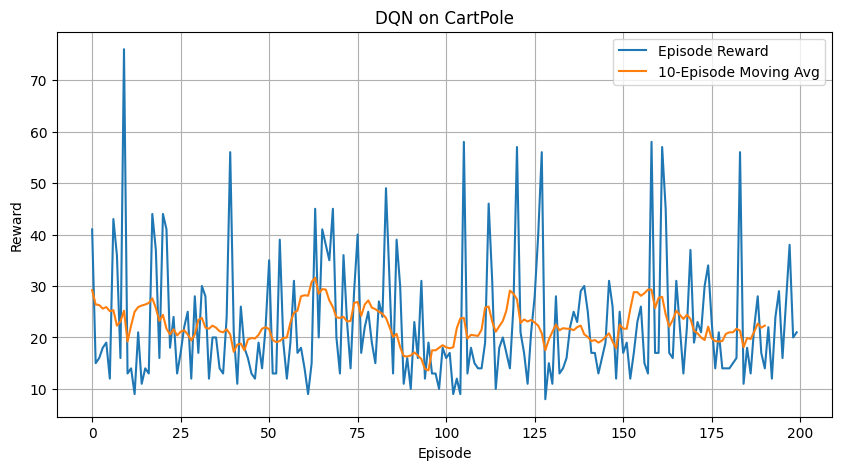

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam

class DQNAgent:
    def __init__(self):
        self.model=self.create_model()
        self.target_model=self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        self.replay_memory=deque(maxlen=REPLAY_MEMORY_SIZE)
        self.target_update_counter=0

    def create_model(self):
        model = Sequential()
        model.add(Dense(64, input_shape=OBSERVATION_SPACE_VALUES, activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(ACTION_SPACE_SIZE, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
        return model

    def update_replay_memory(self,transition):
        self.replay_memory.append(transition)

    def get_qs(self,state):
        return self.model.predict(np.array(state).reshape(-1,*state.shape)/255)

    def train(self,terminal_state,step):
        if len(self.replay_memory)<MIN_REPLAY_MEMORY_SIZE:
            return
        minibatch=random.sample(self.replay_memory,MINIBATCH_SIZE)
        current_states=np.array([transition[0] for transition in minibatch])/255
        current_qs_list=self.model.predict(current_states)
        new_current_states=np.array([transition[3] for transition in minibatch])
        future_qs_list=self.target_model.predict(new_current_states)

        X=[]
        Y=[]
        for index,(current_state,action,reward,new_current_state,done) in enumerate(minibatch):
            if not done:
               max_future_q=np.max(future_qs_list[index])
               new_q=reward+DISCOUNT*max_future_q
            else:
              new_q=reward

            current_qs=current_qs_list[index]
            current_qs[action]=new_q

            X.append(current_state)
            Y.append(current_qs)

        self.model.fit(np.array(X)/255,np.array(Y),batch_size=MINIBATCH_SIZE,verbose=0,shuffle=False)

        if terminal_state:
            self.target_update_counter+=1

        if self.target_update_counter>UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter=0


env = gym.make("CartPole-v1")
OBSERVATION_SPACE_VALUES = env.observation_space.shape
ACTION_SPACE_SIZE = env.action_space.n
REPLAY_MEMORY_SIZE = 50_000
MIN_REPLAY_MEMORY_SIZE = 1_000
MINIBATCH_SIZE = 64
DISCOUNT = 0.99
UPDATE_TARGET_EVERY = 5
MODEL_NAME = "DQN_CartPole"
n_episodes = 200
rewards = []
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001
agent=DQNAgent()
for episode in range(n_episodes):
    current_state, _ = env.reset()
    done = False
    total_reward = 0
    step = 1

    while not done:
        if np.random.random() > epsilon:
            action = np.argmax(agent.get_qs(current_state)[0])
        else:
            action = np.random.randint(0, ACTION_SPACE_SIZE)

        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        total_reward += reward
        step += 1

    rewards.append(total_reward)
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

    print(f"Episode: {episode+1}, Reward: {total_reward}, Epsilon: {epsilon:.5f}")

# Plotting rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Episode Reward")
plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), label="10-Episode Moving Avg")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN on CartPole")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")
n_episodes = 200
rewards = []

for episode in range(n_episodes):
    obs,_ = env.reset()
    done = False
    total_reward = 0

    while not done:
        if np.random.random()>epsilon:
            action=np.argmax(agent.get_qs(current_state))
        else:
            action=np.random.randint(0,env.ACTION_SPACE_SIZE)
        step_result = env.step(action)

        obs, reward, terminated, truncated, _ = step_result
        done = terminated or truncated
        agent.update_replay_memory((current_state,action,reward,new_state,done))
        agent.train(done,step)
        current_state=new_state

        total_reward += reward

    rewards.append(total_reward)

# Plotting rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Episode Reward")
plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), label="10-Episode Moving Avg")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Random Policy on CartPole")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'epsilon' is not defined